In [107]:
import numpy as np
import pandas as pd
import matplotlib
from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

In [108]:
all_cont = pd.read_csv('all_contracts.csv', index_col= 'tradeDate')
all_cont.index = pd.to_datetime(all_cont.index)
all_cont.head()

,M,SR,FG,CU,SN,NI,RM,AG,OI,CF,...,P,C,BU,PP,JM,RU,AL,Y,CS,L
tradeDate,,,,,,,,,,,,,,,,,,,,,
2015-03-27,2775.0,5242.0,946.0,43870.0,119230.0,101180.0,2236.0,3671.0,5872.0,13175.0,...,4716.0,2535.0,3140.0,8219.0,696.0,12810.0,13325.0,5446.0,3062.0,9600.0
2015-03-30,2768.0,5343.0,971.0,43620.0,117720.0,98390.0,2242.0,3637.0,5830.0,13220.0,...,4668.0,2529.0,3102.0,8182.0,696.0,12720.0,13315.0,5392.0,3069.0,9625.0
2015-03-31,2752.0,5364.0,966.0,43770.0,117790.0,95950.0,2230.0,3588.0,5826.0,13145.0,...,4660.0,2524.0,3106.0,8248.0,684.0,12635.0,13375.0,5372.0,3078.0,9730.0
2015-04-01,2789.0,5392.0,946.0,43380.0,118280.0,92870.0,2271.0,3573.0,5852.0,13045.0,...,4658.0,2521.0,3086.0,8300.0,683.0,12620.0,13370.0,5364.0,3010.0,9675.0
2015-04-02,2803.0,5415.0,932.0,43350.0,118540.0,94320.0,2271.0,3604.0,5856.0,13040.0,...,4656.0,2525.0,3198.0,8460.0,682.0,12765.0,13370.0,5386.0,3006.0,9860.0


In [109]:
def find_coint_pairs(df, critical_val = 0.05):
    n = df.shape[1] ## Number of different stocks
    p_value_mat = np.zeros((n, n))

    stocks = df.keys()
    feasible_pairs = []
    for i in range(0, n):
        s1 = df[stocks[i]]
        for j in range(i + 1, n):
            s2 = df[stocks[j]]
            
            p_val = (ts.coint(s1, s2))[1]

            p_value_mat[i, j] = p_val
            if p_val < critical_val: ## The pair is cointegrated
                row = [stocks[i], stocks[j], p_val]
                feasible_pairs.append(row)
    feasible_pairs = pd.DataFrame(feasible_pairs, columns = ['S1', 'S2', 'Pvalue'])
    return p_value_mat, feasible_pairs



In [110]:
pvalue_matrix, pairs = find_coint_pairs(all_cont)
print(pairs)

    S1  S2    Pvalue
0    M  AG  0.038734
1   FG  RB  0.044673
2   FG  ZN  0.010577
3   CU  SF  0.010265
4   NI  PP  0.024477
5   NI   L  0.028088
6   RM  AG  0.022726
7   OI   I  0.017839
8   OI   V  0.008825
9   OI  JM  0.015580
10  OI   L  0.041119
11  HC  PB  0.028859
12  HC  ZN  0.006570
13   J  PB  0.008268
14   J  TC  0.043154
15   J  ZN  0.001432
16   I  RU  0.043780
17  TA  PB  0.035786
18  TA  RB  0.015571
19  TA  MA  0.000007
20  TA  ZN  0.020002
21  TA  BU  0.043501
22  TA  PP  0.001232
23  TA  RU  0.028487
24  TA  AL  0.038053
25  TA   L  0.002110
26  PB  RB  0.012524
27  PB  JM  0.004836
28  RB  ZN  0.000046
29  RB  SF  0.047075
30   V  JM  0.006648
31  TC  ZN  0.042567
32  SF  AL  0.015379


In [111]:
pairs.to_csv('training_self_p_sorted.csv')

In [112]:
data2 = pd.read_csv('training data.csv',index_col='tradeDate')
data2.index = pd.to_datetime(data2.index)
data2.head()

,M,SR,FG,CU,SN,NI,RM,AG,OI,CF,...,P,C,BU,PP,JM,RU,AL,Y,CS,L
tradeDate,,,,,,,,,,,,,,,,,,,,,
2015-03-27,2775.0,5242.0,946.0,43870.0,119230.0,101180.0,2236.0,3671.0,5872.0,13175.0,...,4716.0,2535.0,3140.0,8219.0,696.0,12810.0,13325.0,5446.0,3062.0,9600.0
2015-03-30,2768.0,5343.0,971.0,43620.0,117720.0,98390.0,2242.0,3637.0,5830.0,13220.0,...,4668.0,2529.0,3102.0,8182.0,696.0,12720.0,13315.0,5392.0,3069.0,9625.0
2015-03-31,2752.0,5364.0,966.0,43770.0,117790.0,95950.0,2230.0,3588.0,5826.0,13145.0,...,4660.0,2524.0,3106.0,8248.0,684.0,12635.0,13375.0,5372.0,3078.0,9730.0
2015-04-01,2789.0,5392.0,946.0,43380.0,118280.0,92870.0,2271.0,3573.0,5852.0,13045.0,...,4658.0,2521.0,3086.0,8300.0,683.0,12620.0,13370.0,5364.0,3010.0,9675.0
2015-04-02,2803.0,5415.0,932.0,43350.0,118540.0,94320.0,2271.0,3604.0,5856.0,13040.0,...,4656.0,2525.0,3198.0,8460.0,682.0,12765.0,13370.0,5386.0,3006.0,9860.0


In [113]:
def load_data():
    all_cont = pd.read_csv('training data.csv',index_col='tradeDate',parse_dates=True)
    pairs_p_sorted = pd.read_csv('training_self_p_sorted.csv', index_col='Unnamed: 0',parse_dates=False)
    return all_cont, pairs_p_sorted

In [114]:
def hurst_test(time_ser):
    lags = [i for i in range(2, 200)]
    tau = [(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags] ## Root(Variance) = std_dev
    poly = polyfit(log(lags), log(tau), 1) ## np.polyfit(x, y, deg), linear regression to find slope
    return poly[0] ## Return value is an array of coeffecients in descending order of powers, poly[0] is the slope

In [115]:
def adf_test_spread(x, y): ## a stationarity test, of the residual of stock prices x and y
    df = pd.DataFrame({'x': x, 'y' : y})
    est = sm.OLS(df.y, df.x) ## OLS = Ordinary Least Squares, for linear regression
    est.fit()
    df['hedge_ratio'] = est.params[0]
    df['intercept'] = est.params[1]
    df['spread'] = df.y - df.x * df.hedge_ratio - df.intercept
    res = ts.adfuller(df['spread'])
    return res[1]

In [116]:
def half_life_spread(x):
    
    x_lag = x.shift(1)
    x_lag.iloc[0] = x_lag.iloc[1]
    diff = x - x_lag
    diff.iloc[0] = diff.iloc[1]
    
    x_lag_2 = sm.add_constant(x_lag)
    est = sm.OLS(diff, x_lag_2)
    res = est.fit()

    half_life = int(round(-np.log(2) / res.params[1],0))
    if half_life <= 0:
        half_life = 1
    return half_life
    # spread_lag = spread.shift(1)
    # spread_lag.iloc[0] = spread_lag.iloc[1] ## To compensate for the NaN at index 0

    # spread_ret = spread - spread_lag
    # spread_ret.iloc[0] = spread_ret.iloc[1]

    # spread_lag2 = sm.add_constant(spread_lag)

    # model = sm.OLS(spread_ret,spread_lag2)
    # res = model.fit()
    # halflife = int(round(-np.log(2) / res.params[1],0))

    # if halflife <= 0:
    #     halflife = 1
    # return halflife

In [117]:
def KF_Avg(x):
    """Smoothens a stock price series, removing all possible noise"""
    kf = KalmanFilter(transition_matrices = [1], ## System Model: priori_price_on_next_day = price_on_last_day
                      observation_matrices = [1], ## Measuring stock price on the next day
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, state_covs = kf.filter(x.values) ## x is assumed to be sequential measurements of the stock price
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

In [118]:
def KF_linear_regression(x, y):
    """Uses a Kalman Filter to determine the linear regression parameters for stocks x and y"""
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    ## alpha is intercept, beta is the slope

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y (obs) is 1-dimensional, (beta, alpha) (state) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance = np.ones((2, 2)),
                      transition_matrices = np.eye(2), ## priori params = previous_day_params
                      observation_matrices = obs_mat, ## H of each iteration of the kf algo ** (the observation matrix is not static)
                      observation_covariance = 2, ## 2
                      transition_covariance = trans_cov)
    
    state_means, state_covs = kf.filter(y.values)
    return state_means

In [119]:
def backtest(x, y):
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KF_linear_regression(KF_Avg(x), KF_Avg(y))

    df1['hr'] = state_means[:,0] ## The hedge ratio
    df1['intercept'] = state_means[:, 1]
    df1['spread'] = df1.y - (df1.x * df1.hr) ##- df1.intercept

    halflife = half_life_spread(df1['spread'])

    meanSpread = df1.spread.rolling(window= 1 * halflife).mean()
    stdSpread = df1.spread.rolling(window= 1 * halflife).std()

    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    entryZscore = 2
    exitZscore = 0

    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & ( df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1 ## num units long updated for the indices where df1['long entry'] is true
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad') ## each NaN filled with the prev non-NaN value


    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) <  entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & ( df1.zScore.shift(1) >  exitZscore))
    df1['num units short'] = np.nan
    df1.loc[df1['short entry'],'num units short'] = -1 ## num units short updated for the indices where df1['short entry'] is true
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad') ## each NaN filled with the prev non-NaN value

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread_pct_chg'] = df1.spread.diff()/df1.spread
    df1['port rets'] = df1['spread_pct_chg'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    return df1['cum rets'], sharpe


In [120]:
all_contracts, p_sorted = load_data()

In [121]:
list_sect = []
ret = pd.DataFrame()
for i in np.arange(p_sorted.shape[0]):


    # print("The total # of testing is: ", p_sorted.shape[0], " Current: ", i)
    s1 = p_sorted.iloc[i][1]
    s2 = p_sorted.iloc[i][0]

    name = s1 + "-" + s2

    x = all_contracts[s1]
    y = all_contracts[s2]

    tmp, sharpe = backtest(x, y)
    if sharpe > 0.5 and tmp.values[-1] > 1.105:
        ret[name] = tmp.values
        list_sect.append((s1,s2))

# List the potential pairs for out-sample testing
list_sect

[('ZN', 'FG'),
 ('SF', 'CU'),
 ('V', 'OI'),
 ('JM', 'OI'),
 ('PB', 'HC'),
 ('PB', 'J'),
 ('TC', 'J'),
 ('RU', 'I'),
 ('RB', 'TA'),
 ('MA', 'TA'),
 ('ZN', 'TA'),
 ('BU', 'TA'),
 ('ZN', 'TC'),
 ('AL', 'SF')]

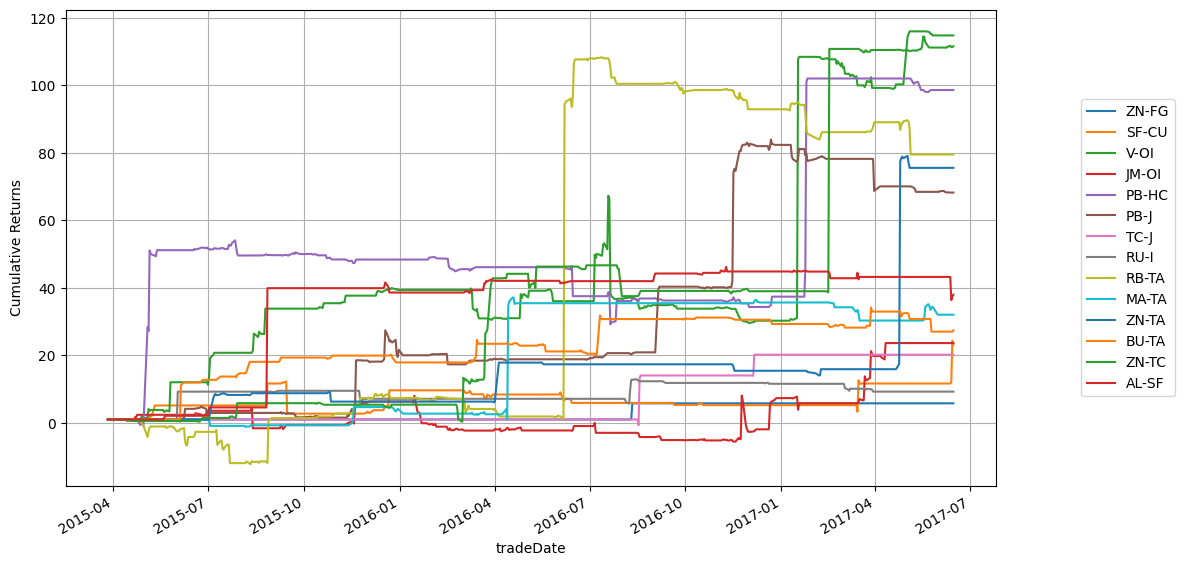

In [122]:
ret.iloc[0] = 1
ret.index = all_contracts.index
ret.plot(figsize=(12,7),grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Cumulative Returns')
plt.show()

In [123]:
perf = ret.calc_stats()
perf.display()

Stat                 ZN-FG       SF-CU       V-OI        JM-OI       PB-HC       PB-J        TC-J        RU-I        RB-TA       MA-TA       ZN-TA       BU-TA       ZN-TC       AL-SF
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27  2015-03-27
End                  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15  2017-06-15
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         478.68%     2213.50%    11383.80%   2265.18%    

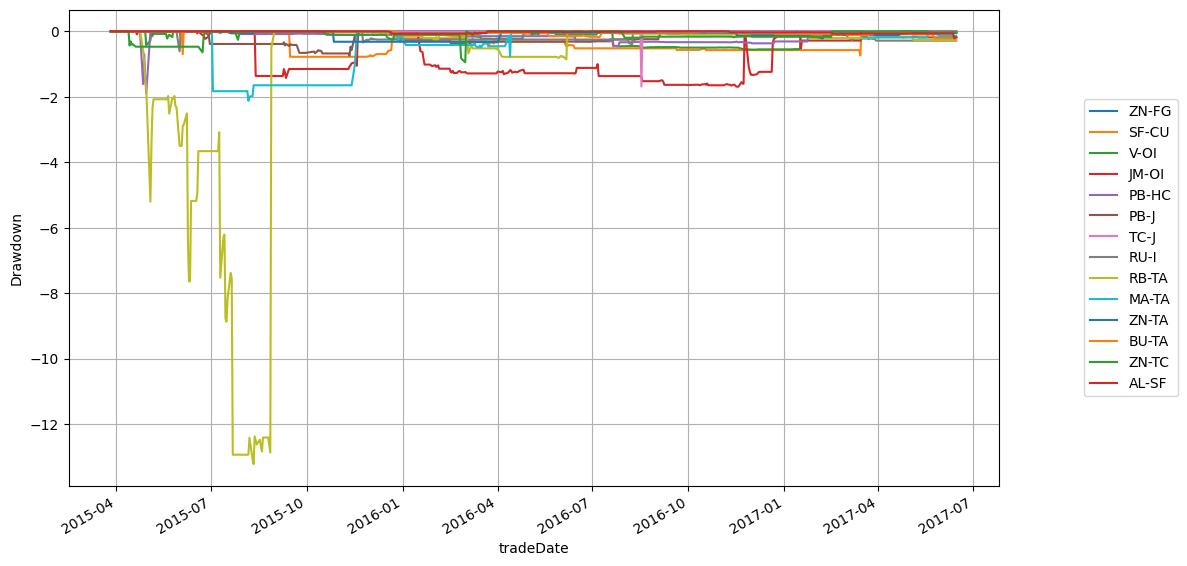

In [124]:
ffn.to_drawdown_series(ret).plot(figsize=(12,7),grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Drawdown')
plt.show()

start                    2015-03-27 00:00:00
end                      2017-06-15 00:00:00
rf                                       0.0
total_return                       51.001512
cagr                                4.927096
max_drawdown                       -0.225614
calmar                             21.838636
mtd                                 0.009389
three_month                         0.129335
six_month                           0.631155
ytd                                 0.591426
one_year                            0.996651
three_year                          4.927096
five_year                                NaN
ten_year                                 NaN
incep                               4.927096
daily_sharpe                        1.513536
daily_sortino                      14.432991
daily_mean                          2.505414
daily_vol                           1.655338
daily_skew                         18.945607
daily_kurt                        400.621924
best_day  

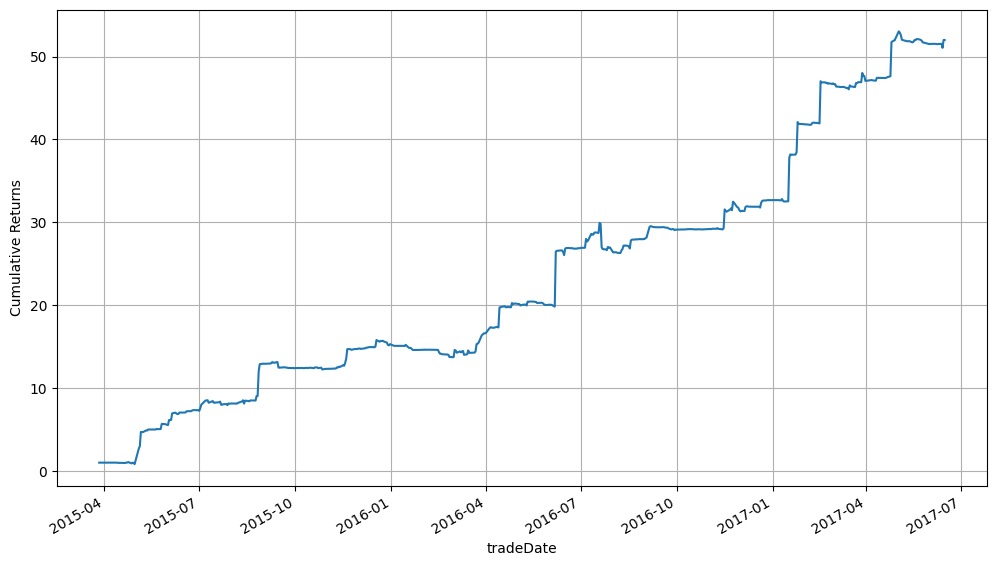

In [125]:
port = ret.mean(axis=1)
port.plot(figsize=(12,7),grid=True)
perf = port.calc_stats()
plt.ylabel('Cumulative Returns')
perf.stats

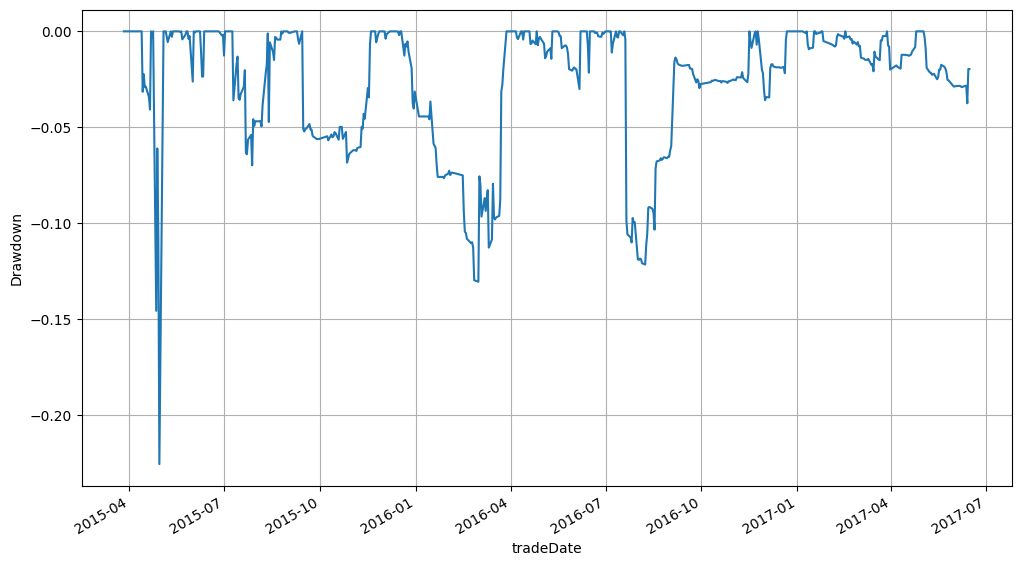

In [126]:
ffn.to_drawdown_series(port).plot(figsize=(12,7),grid=True)
plt.ylabel('Drawdown')
plt.show()

In [127]:
# Read testing data
testing_data = pd.read_csv('testing data.csv',index_col='tradeDate',parse_dates=True)

test_ret = pd.DataFrame()
for i in np.arange(len(list_sect)):

    # print("The total # of testing is: ", p_sorted.shape[0], " Current: ", i)
    s1 = list_sect[i][1]
    s2 = list_sect[i][0]

    name = s1 + "-" + s2

    x = testing_data[s1]
    y = testing_data[s2]

    test_ret[name], sharpe = backtest( x, y)

In [128]:
test_ret.iloc[0] = 1
test_ret.tail(3)

,FG-ZN,CU-SF,OI-V,OI-JM,HC-PB,J-PB,J-TC,I-RU,TA-RB,TA-MA,TA-ZN,TA-BU,TC-ZN,SF-AL
tradeDate,,,,,,,,,,,,,,
2017-12-27,0.31793,11.767435,4.283038,8.329841,1.0,-31.218317,23.223899,1.0,1.0,1.0,0.585540,-4.028479,19.196086,-11.180291
2017-12-28,0.31793,11.949431,4.283038,8.329841,1.0,-31.574436,23.223899,1.0,1.0,1.0,-0.101740,-4.028479,19.029740,-11.459036
2017-12-29,0.31793,11.937858,4.283038,8.329841,1.0,-31.277559,23.223899,1.0,1.0,1.0,-0.147458,-4.028479,19.021198,-11.551028


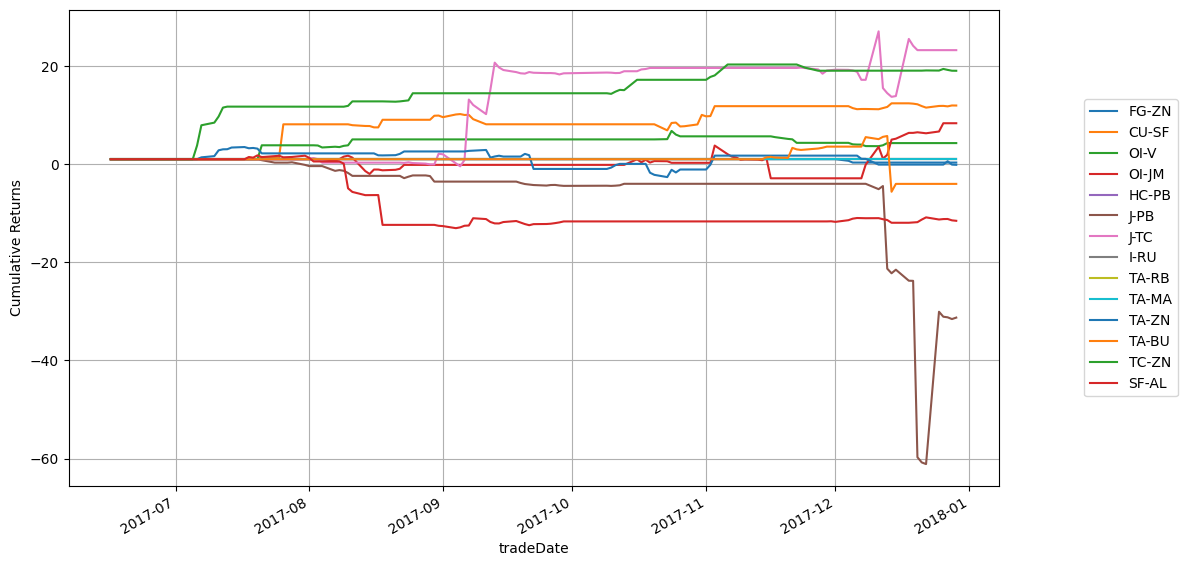

In [129]:
test_ret.plot(figsize=(12,7),grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Cumulative Returns')
plt.show()

start                    2017-06-16 00:00:00
end                      2017-12-29 00:00:00
rf                                       0.0
total_return                        0.722089
cagr                                1.753558
max_drawdown                       -1.128437
calmar                               1.55397
mtd                                -0.476575
three_month                        -0.307978
six_month                           0.722089
ytd                                 0.722089
one_year                                 NaN
three_year                               NaN
five_year                                NaN
ten_year                                 NaN
incep                               1.753558
daily_sharpe                       -1.138329
daily_sortino                      -1.176825
daily_mean                         -7.084259
daily_vol                           6.223385
daily_skew                         -9.463024
daily_kurt                        100.341641
best_day  

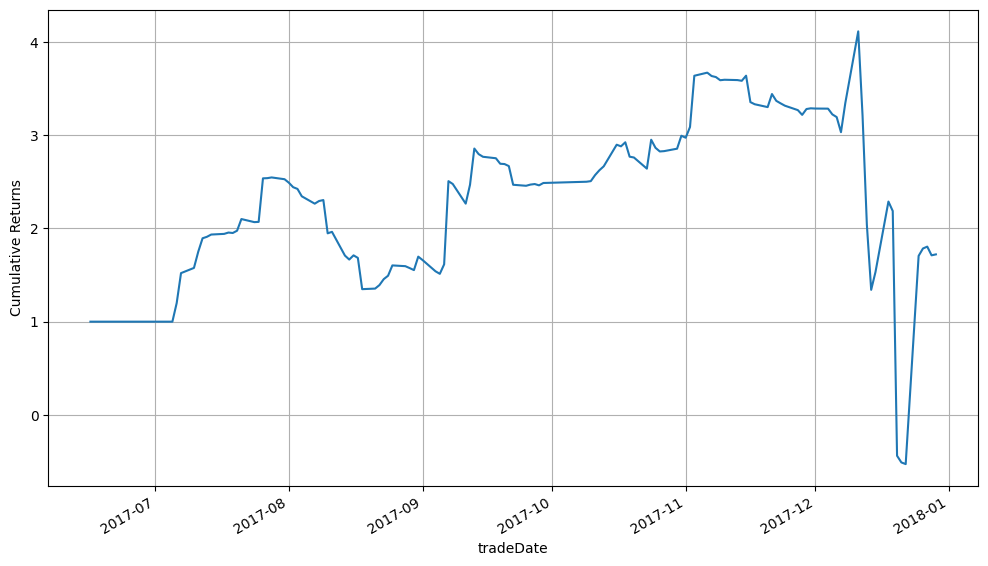

In [130]:
# Out sample back testing of portfolio
port = test_ret.mean(axis=1)
port.plot(figsize=(12,7),grid=True)
perf = port.calc_stats()
plt.ylabel('Cumulative Returns')
perf.stats

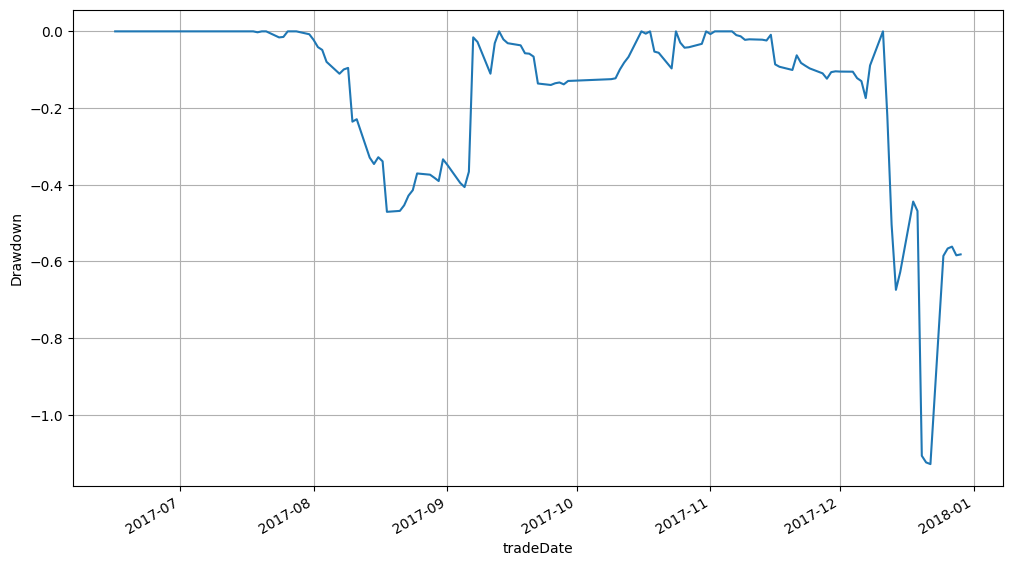

In [131]:
ffn.to_drawdown_series(port).plot(figsize=(12,7),grid=True)
plt.ylabel('Drawdown')
plt.show()

In [171]:
def backtest2(x, y):
    df1 = pd.DataFrame({'y':y,'x':x})
    # state_means = KF_linear_regression(KF_Avg(x), KF_Avg(y))
    x = KF_Avg(x)
    y = KF_Avg(y)
    x_pad = sm.add_constant(x)
    mod = sm.RecursiveLS(y, x_pad)
    res = mod.fit()
    df1['hr'] = pd.Series(res.recursive_coefficients['filtered'][1], index = x.index)
    df1['intercept'] = pd.Series(res.recursive_coefficients['filtered'][0], index = x.index)
    # df1['hr'] = state_means[:,0] ## The hedge ratio
    # df1['intercept'] = state_means[:, 1]
    df1['spread'] = df1.y - (df1.x * df1.hr) ##- df1.intercept

    halflife = half_life_spread(df1['spread'])

    meanSpread = df1.spread.rolling(window= 1 * halflife).mean()
    stdSpread = df1.spread.rolling(window= 1 * halflife).std()

    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    entryZscore = 2
    exitZscore = 0

    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & ( df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1 ## num units long updated for the indices where df1['long entry'] is true
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad') ## each NaN filled with the prev non-NaN value


    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) <  entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & ( df1.zScore.shift(1) >  exitZscore))
    df1['num units short'] = np.nan
    df1.loc[df1['short entry'],'num units short'] = -1 ## num units short updated for the indices where df1['short entry'] is true
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad') ## each NaN filled with the prev non-NaN value

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread_pct_chg'] = df1.spread.diff()/df1.spread
    df1['port rets'] = df1['spread_pct_chg'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    return df1['cum rets'], sharpe


In [133]:
x_pad = sm.add_constant(x)
mod = sm.RecursiveLS(y, x_pad)
res = mod.fit()

In [134]:
x_pad

,const,SF
tradeDate,,
2017-06-16,1.0,5424.0
2017-06-19,1.0,5448.0
2017-06-20,1.0,5390.0
2017-06-21,1.0,5476.0
2017-06-22,1.0,5568.0
...,...,...
2017-12-25,1.0,6858.0
2017-12-26,1.0,6760.0
2017-12-27,1.0,6788.0


In [172]:
# Read testing data
testing_data = pd.read_csv('testing data.csv',index_col='tradeDate',parse_dates=True)

test_ret = pd.DataFrame()
for i in np.arange(len(list_sect)):

    # print("The total # of testing is: ", p_sorted.shape[0], " Current: ", i)
    s1 = list_sect[i][1]
    s2 = list_sect[i][0]

    name = s1 + "-" + s2

    x = testing_data[s1]
    y = testing_data[s2]

    test_ret[name], sharpe = backtest2( x, y)

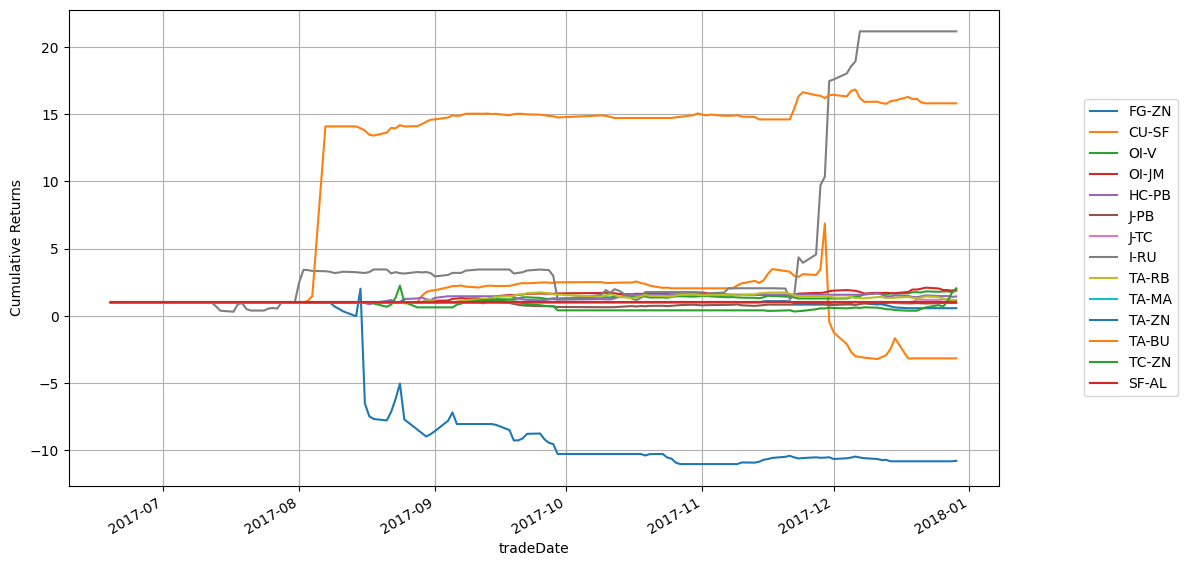

In [173]:
test_ret.plot(figsize=(12,7),grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Cumulative Returns')
plt.show()

start                    2017-06-16 00:00:00
end                      2017-12-29 00:00:00
rf                                       0.0
total_return                             NaN
cagr                                5.038973
max_drawdown                       -0.371975
calmar                             13.546537
mtd                                 0.051192
three_month                         0.902741
six_month                           1.586217
ytd                                 1.586217
one_year                                 NaN
three_year                               NaN
five_year                                NaN
ten_year                                 NaN
incep                               5.038973
daily_sharpe                        1.922775
daily_sortino                       4.842025
daily_mean                          2.438852
daily_vol                           1.268402
daily_skew                          5.787584
daily_kurt                         57.040031
best_day  

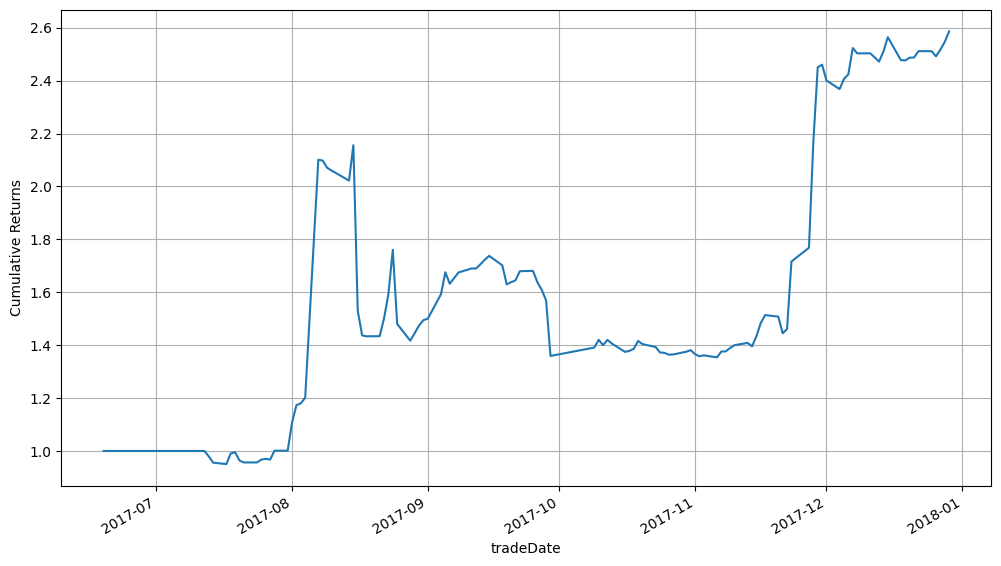

In [174]:
port = test_ret.mean(axis=1)
port.plot(figsize=(12,7),grid=True)
perf = port.calc_stats()
plt.ylabel('Cumulative Returns')
perf.stats

start                    2017-06-16 00:00:00
end                      2017-12-29 00:00:00
rf                                       0.0
total_return                             NaN
cagr                                5.038973
max_drawdown                       -0.371975
calmar                             13.546537
mtd                                 0.051192
three_month                         0.902741
six_month                           1.586217
ytd                                 1.586217
one_year                                 NaN
three_year                               NaN
five_year                                NaN
ten_year                                 NaN
incep                               5.038973
daily_sharpe                        1.922775
daily_sortino                       4.842025
daily_mean                          2.438852
daily_vol                           1.268402
daily_skew                          5.787584
daily_kurt                         57.040031
best_day  

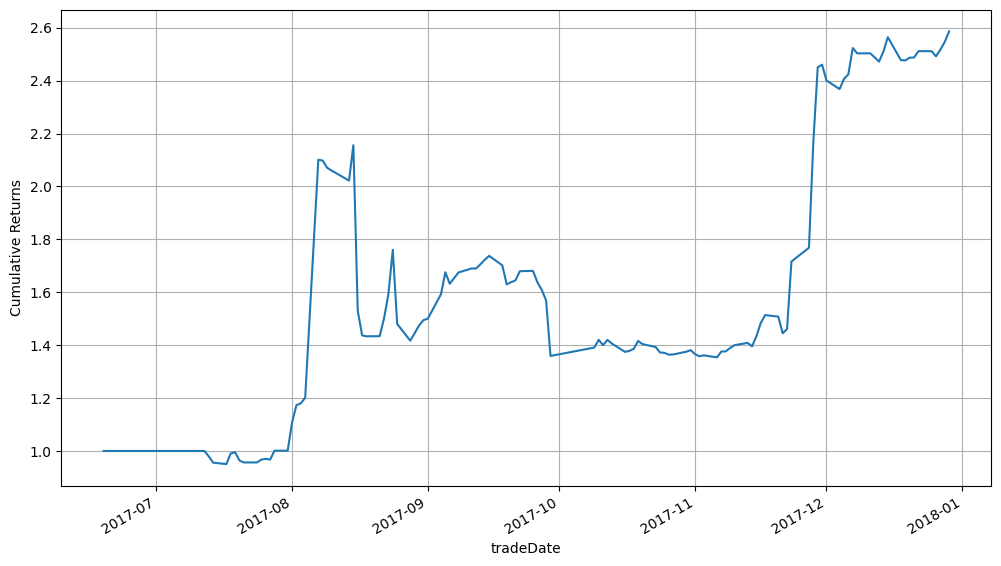

In [138]:
# Out sample back testing of portfolio
port = test_ret.mean(axis=1)
port.plot(figsize=(12,7),grid=True)
perf = port.calc_stats()
plt.ylabel('Cumulative Returns')
perf.stats

In [175]:
def backtest3(x, y):
    df1 = pd.DataFrame({'y':y,'x':x})
    # state_means = KF_linear_regression(KF_Avg(x), KF_Avg(y))
    x = KF_Avg(x)
    y = KF_Avg(y)
    x_pad = sm.add_constant(x)
    mod = sm.RecursiveLS(y, x_pad)
    res = mod.fit()
    df1['hr'] = pd.Series(res.recursive_coefficients['filtered'][1], index = x.index)
    df1['intercept'] = pd.Series(res.recursive_coefficients['filtered'][0], index = x.index)
    # df1['hr'] = state_means[:,0] ## The hedge ratio
    # df1['intercept'] = state_means[:, 1]
    df1['spread'] = df1.y - (df1.x * df1.hr) ##- df1.intercept

    halflife = half_life_spread(df1['spread'])

    meanSpread = df1.spread.rolling(window= 1 * halflife).mean()
    stdSpread = df1.spread.rolling(window= 1 * halflife).std()

    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    entryZscore = 2
    exitZscore = 0

    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & ( df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1 ## num units long updated for the indices where df1['long entry'] is true
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad') ## each NaN filled with the prev non-NaN value


    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) <  entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & ( df1.zScore.shift(1) >  exitZscore))
    df1['num units short'] = np.nan
    df1.loc[df1['short entry'],'num units short'] = -1 ## num units short updated for the indices where df1['short entry'] is true
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad') ## each NaN filled with the prev non-NaN value

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread_pct_chg'] = df1.spread.diff()/df1.spread
    df1['port rets'] = df1['spread_pct_chg'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    return df1['cum rets'], sharpe, df1['spread']


In [140]:
def backtest4(x, y):
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KF_linear_regression(KF_Avg(x), KF_Avg(y))

    df1['hr'] = state_means[:,0] ## The hedge ratio
    df1['intercept'] = state_means[:, 1]
    df1['spread'] = df1.y - (df1.x * df1.hr) ##- df1.intercept

    halflife = half_life_spread(df1['spread'])

    meanSpread = df1.spread.rolling(window= 1 * halflife).mean()
    stdSpread = df1.spread.rolling(window= 1 * halflife).std()

    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    entryZscore = 2
    exitZscore = 0

    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & ( df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1 ## num units long updated for the indices where df1['long entry'] is true
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad') ## each NaN filled with the prev non-NaN value


    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) <  entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & ( df1.zScore.shift(1) >  exitZscore))
    df1['num units short'] = np.nan
    df1.loc[df1['short entry'],'num units short'] = -1 ## num units short updated for the indices where df1['short entry'] is true
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad') ## each NaN filled with the prev non-NaN value

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread_pct_chg'] = df1.spread.diff()/df1.spread
    df1['port rets'] = df1['spread_pct_chg'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    return df1['cum rets'], sharpe, df1['spread']


In [176]:
list_sect

[('ZN', 'FG'),
 ('SF', 'CU'),
 ('V', 'OI'),
 ('JM', 'OI'),
 ('PB', 'HC'),
 ('PB', 'J'),
 ('TC', 'J'),
 ('RU', 'I'),
 ('RB', 'TA'),
 ('MA', 'TA'),
 ('ZN', 'TA'),
 ('BU', 'TA'),
 ('ZN', 'TC'),
 ('AL', 'SF')]

In [200]:
s1 = list_sect[2][1]
s2 = list_sect[2][0]

name = s1 + "-" + s2

x = testing_data[s1]
y = testing_data[s2]

t_ret3, sharpe3, spread3 = backtest3(x, y)
t_ret4, sharpe4, spread4 = backtest4(x, y)

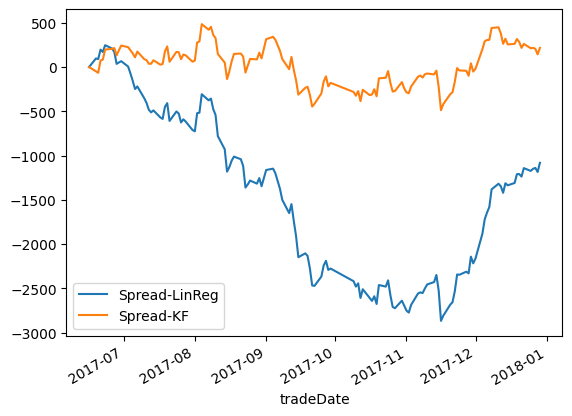

In [201]:
spread3.plot()
spread4.plot()
plt.legend(['Spread-LinReg', 'Spread-KF']) 

In [202]:
df1 = pd.DataFrame()
x = KF_Avg(x)
y = KF_Avg(y)
x_pad = sm.add_constant(x)
mod = sm.RecursiveLS(y, x_pad)
res = mod.fit()
df1['hr'] = pd.Series(res.recursive_coefficients['filtered'][1], index = spread3.index)
df1['intercept'] = pd.Series(res.recursive_coefficients['filtered'][0], index = spread3.index)
state_means = KF_linear_regression(x, y)
df1['hr-kf'] = pd.Series(state_means[:,0], index = spread3.index) ## The hedge ratio
df1['intercept-kf'] = pd.Series(state_means[:,1], index = spread3.index)

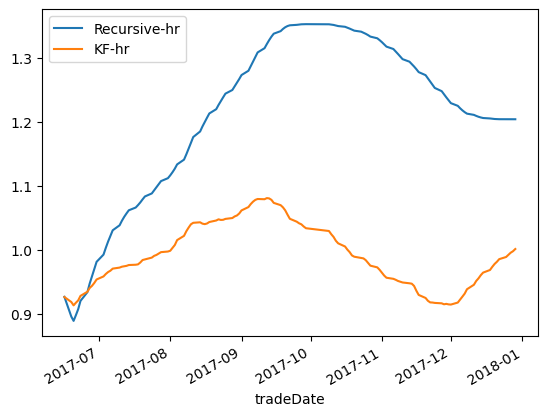

In [203]:
df1['hr'].plot()
df1['hr-kf'].plot()
plt.legend(['Recursive-hr', 'KF-hr'])

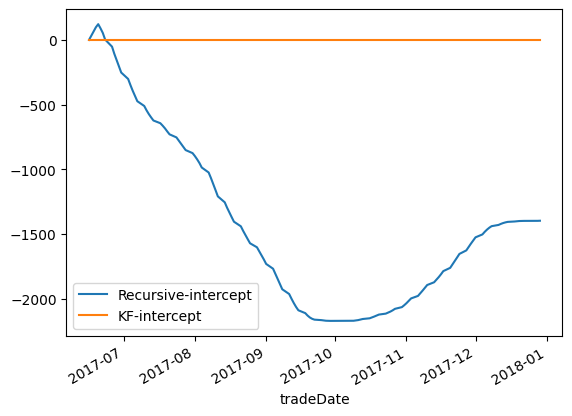

In [204]:
df1['intercept'].plot()
df1['intercept-kf'].plot()
plt.legend(['Recursive-intercept', 'KF-intercept'])

In [205]:
df1['spread-linReg'] = y - df1['hr'] * x # - df1['intercept'] 
df1['spread-kf'] = y - df1['hr-kf'] * x #- df1['intercept-kf']

<Axes: xlabel='tradeDate'>

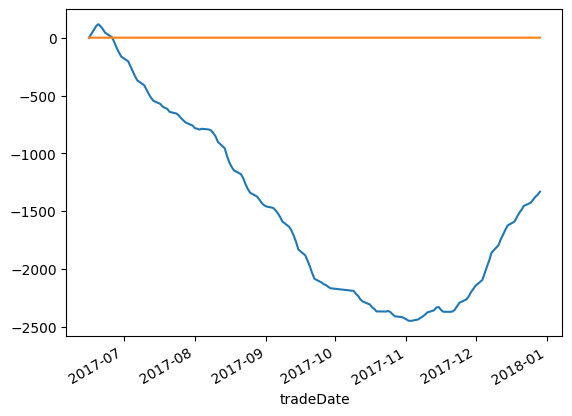

In [206]:
df1['spread-linReg'].plot()
df1['spread-kf'].plot()